In [11]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder

data_dir = "AudioWAV/"
emotion_map = {
    "ANG": "Anger",
    "DIS": "Disgust",
    "FEA": "Fear",
    "HAP": "Happy",
    "NEU": "Neutral",
    "SAD": "Sad"
}

file_paths = []
labels = []

for fname in os.listdir(data_dir):
    if fname.endswith(".wav"):
        parts = fname.split("_")
        emotion_code = parts[2]
        if emotion_code in emotion_map:
            file_paths.append(os.path.join(data_dir, fname))
            labels.append(emotion_map[emotion_code])

In [12]:
import librosa

def extract_mel_spectrogram(file_path, n_mels=256, max_len=256):
    y, sr = librosa.load(file_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    log_mel = librosa.power_to_db(mel_spec)

    # Pad or truncate to fixed length
    if log_mel.shape[1] < max_len:
        pad_width = max_len - log_mel.shape[1]
        log_mel = np.pad(log_mel, pad_width=((0,0), (0, pad_width)), mode='constant')
    else:
        log_mel = log_mel[:, :max_len]

    return log_mel

In [13]:
import pickle
X = []
for path in file_paths:
    spec = extract_mel_spectrogram(path)
    X.append(spec)

X = np.array(X)
X = X[..., np.newaxis]  # (samples, 128, 128, 1)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Normalize
X = X / np.max(X)

# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)
with open("label_encoder-2.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Add early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    epochs=6,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)
model.save("cnn_emotion_model-2.h5")



/Users/shrek/Desktop/courses/semester 8/nlp/NLP-CS4420/project/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
168/168 ━━━━━━━━━━━━━━━━━━━━ 81s 480ms/step - accuracy: 0.2971 - loss: 1.6748 - val_accuracy: 0.4649 - val_loss: 1.3825 - learning_rate: 0.0010
Epoch 2/6
168/168 ━━━━━━━━━━━━━━━━━━━━ 85s 506ms/step - accuracy: 0.4308 - loss: 1.4109 - val_accuracy: 0.4963 - val_loss: 1.3039 - learning_rate: 0.0010
Epoch 3/6
168/168 ━━━━━━━━━━━━━━━━━━━━ 89s 532ms/step - accuracy: 0.4831 - loss: 1.3123 - val_accuracy: 0.4918 - val_loss: 1.2703 - learning_rate: 0.0010
Epoch 4/6
168/168 ━━━━━━━━━━━━━━━━━━━━ 101s 603ms/step - accuracy: 0.5362 - loss: 1.1980 - val_accuracy: 0.5112 - val_loss: 1.2487 - learning_rate: 0.0010
Epoch 5/6
168/168 ━━━━━━━━━━━━━━━━━━━━ 103s 611ms/step - accuracy: 0.5586 - loss: 1.1334 - val_accuracy: 0.5291 - val_loss: 1.2289 - learning_rate: 0.0010
Epoch 6/6
168/168 ━━━━━━━━━━━━━━━━━━━━ 108s 642ms/step - accuracy: 0.5827 - loss: 1.0754 - val_accuracy: 0.4836 - val_loss: 1.3069 - learning_rate: 0.0010


In [17]:
from tensorflow.keras.models import load_model
# Load model and label encoder
model = load_model("cnn_emotion_model-2.h5")
with open("label_encoder-2.pkl", "rb") as f:
    label_encoder = pickle.load(f)

def predict_emotion_from_audio(audio_path):
    # Load audio
    y, sr = librosa.load(audio_path, sr=22050)
    
    # Extract Mel spectrogram with 256 Mel bands
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Resize time dimension to 256
    if mel_db.shape[1] < 256:
        pad_width = 256 - mel_db.shape[1]
        mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :256]

    # Reshape for CNN input
    mel_db = mel_db.reshape(1, 256, 256, 1)
    mel_db = mel_db / np.max(mel_db)

    # Predict
    prediction = model.predict(mel_db)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label[0]


In [18]:

# Example usage
print(predict_emotion_from_audio("AudioWAV/1083_IOM_FEA_XX.wav"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Anger


/var/folders/5v/19pdwzv572b5vtt6l96sc4t40000gn/T/ipykernel_51594/1805908227.py:24: RuntimeWarning: divide by zero encountered in divide
  mel_db = mel_db / np.max(mel_db)
/var/folders/5v/19pdwzv572b5vtt6l96sc4t40000gn/T/ipykernel_51594/1805908227.py:24: RuntimeWarning: invalid value encountered in divide
  mel_db = mel_db / np.max(mel_db)


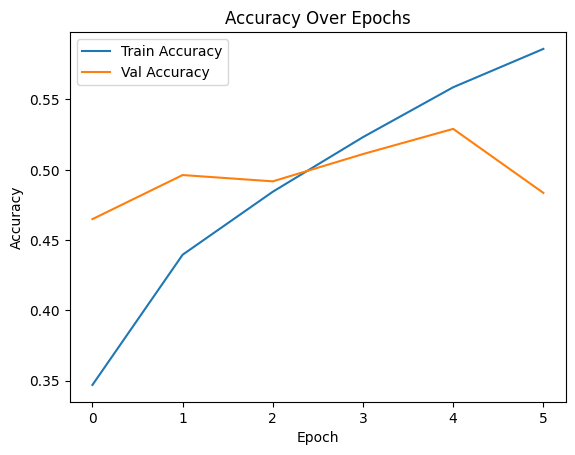

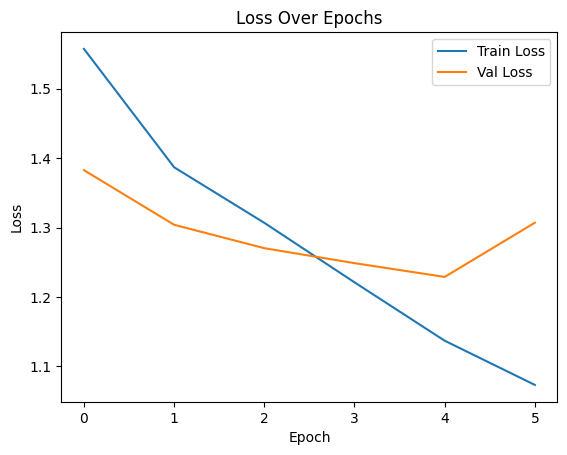

In [19]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

# Load model and tokenizer
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

# GoEmotions labels used by the model
goemotions_labels = [
    'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'
]

# Map GoEmotions labels to CREMA-D's 6 classes
go_to_crema_map = {
    "anger": "Anger",
    "annoyance": "Anger",
    "disgust": "Disgust",
    "fear": "Fear",
    "nervousness": "Fear",
    "joy": "Happy",
    "excitement": "Happy",
    "sadness": "Sad",
    "grief": "Sad",
    "neutral": "Neutral"
}

from collections import Counter

def predict_emotion(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)[0]

    # Get top 3 GoEmotions
    top_indices = torch.topk(probs, 3).indices.tolist()
    top_go_labels = [goemotions_labels[i] for i in top_indices]

    # Map to CREMA-D categories and vote
    mapped = [go_to_crema_map.get(label) for label in top_go_labels if label in go_to_crema_map]
    if mapped:
        final = Counter(mapped).most_common(1)[0][0]
    else:
        final = "Unknown"

    return final, {label: probs[i].item() for i, label in enumerate(goemotions_labels)}


text = "I am so happy to see you!"
emotion, scores = predict_emotion(text)
print(f"Predicted CREMA-D Emotion: {emotion}")



/Users/shrek/Desktop/courses/semester 8/nlp/NLP-CS4420/project/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Predicted CREMA-D Emotion: Happy


In [21]:
import numpy as np

# CREMA-D target classes
crema_labels = ["Anger", "Disgust", "Fear", "Happy", "Neutral", "Sad"]

def predict_text_probs(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)[0]

    # Initialize zero vector for 6-class CREMA-D
    crema_probs = {label: 0.0 for label in crema_labels}

    # Map GoEmotions scores to CREMA-D
    for i, go_label in enumerate(goemotions_labels):
        mapped = go_to_crema_map.get(go_label)
        if mapped:
            crema_probs[mapped] += probs[i].item()

    # Convert to numpy array in correct order
    return np.array([crema_probs[label] for label in crema_labels]).reshape(1, -1)


def fuse_predictions(audio_path, text, alpha=0.5):
    # CNN speech model
    y_audio, sr = librosa.load(audio_path, sr=22050)
    mel = librosa.feature.melspectrogram(y=y_audio, sr=sr, n_mels=256)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db = np.pad(mel_db, ((0, 0), (0, max(0, 256 - mel_db.shape[1]))), mode='constant')[:, :256]
    mel_db = mel_db.reshape(1, 256, 256, 1)
    mel_db = mel_db / np.max(mel_db)
    speech_probs = cnn_model.predict(mel_db)

    # BERT text model
    text_probs = predict_text_probs(text)

    # Fuse predictions
    final_probs = alpha * speech_probs + (1 - alpha) * text_probs
    final_label = crema_labels[np.argmax(final_probs)]

    return final_label, final_probs